# Harris County Home Price Estimations

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import xlabel
from scipy.special import title
from scipy.stats import boxcox

from scipy.stats import shapiro
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Building and Real Account Data
This has the base features to include for the model. In this file I am only pulling the continuous data. So using the date built, improvement square feet, gross area, base area, land area, perimeter and size index to estimate the assessed_val.

In [2]:
con = sqlite3.connect('HouseProtestValues.db')
sql_query = '''SELECT  br.acct,
                       br.bld_num,
                       br.date_erected,
                       br.im_sq_ft,
                       br.gross_ar,
                       br.base_ar,
                       ra.land_ar,
                       br.perimeter,
                       br.size_index,
                       ra.land_val,
                       ra.bld_val,
                       ra.assessed_val,
                       ra.tot_appr_val,
                       ra.tot_mkt_val
            FROM building_res as br
            LEFT JOIN real_acct as ra ON br.acct = ra.acct
            WHERE br.impr_tp = 1001 AND br.property_use_cd = 'A1' AND br.date_erected > 10;'''

base_df = pd.read_sql_query(sql_query, con)

## Fixtures Data
This has features such as, number of rooms such as bedrooms (RMB), full bath (RMF), half bath (RMH) and total rooms (RMT). This will be merged in a pandas dataframe based on the account number and building number. This data was storred in a table format with multiple accounts and building numbers for each feature, so I created a pivot table with the features as columns.

In [3]:
# Story Height Index: STY
# Room: Bedroom: RMB
# Room: Full Bath: RMF
# Room: Half Bath: RMH
# Room: Total: RMT
fixtures_sql = """SELECT *
                  FROM fixtures
                  WHERE type IN ('STY', 'RMB','RMF','RMH','RMT')
                """
fixtures = pd.read_sql_query(fixtures_sql, con)

# Pivot table
fix_pt = fixtures.pivot_table(index=['acct', 'bld_num'], columns='type', values='units', aggfunc='sum')
fix_pt = fix_pt.reset_index()
fix_pt.fillna(0, inplace=True)

## Lat & Long Exports from qGIS
Part of the data provided by HCAD was GIS files. I used QGIS to generate the latitude and longitude coordinates for each parcel in Harris County. This CSV will use the account number to match the lat & long to the base_df.

In [4]:
parcel_df = pd.read_csv('Data/parcels.csv', low_memory=False)
parcel_df.head()

LOWPARCELI       HCAD_NUM                  CurrOwner  \
0  1383880010006  1177990010001   25 NORTH MAIN STREET LLC   
1  1059741170002  1059741170002           COUNTY OF HARRIS   
2   441720000105   441720000105               WEBB PEARSON   
3   441720000135   441720000135      TEXACO EXP & PROD INC   
4   441720000045   441720000045  BALBOA GROUP PARTNERS LLP   

               LocAddr  LocNum         LocName    city      zip  parcel_typ  \
0  4407 TOWN CENTER PL    4407     TOWN CENTER  HUMBLE  77339.0           0   
1    703 TIMBERLINE CT     703      TIMBERLINE  HUMBLE  77339.0           0   
2  0 MOONSHINE HILL RD       0  MOONSHINE HILL  HUMBLE  77338.0           0   
3  0 MOONSHINE HILL RD       0  MOONSHINE HILL  HUMBLE  77338.0           0   
4  0 MOONSHINE HILL RD       0  MOONSHINE HILL  HUMBLE  77338.0           0   

   StatedArea  Acreage SiteNumber  Stacked mill_cd   Shape_Leng  \
0         NaN  Stacked        NaN        1     MAR   581.158311   
1         NaN  Stacked        NaN        1     MAR   206.332803   
2         NaN  Stacked        NaN        1     MEC  6363.363601   
3         NaN  Stacked        NaN        1     MEC  3291.193162   
4         NaN  Stacked        NaN        1     MEC  6018.401902   

      Shape_Area        lat       long  
0   19845.995654 -95.185935  30.048440  
1    2659.602062 -95.243597  30.026801  
2  317061.568381 -95.239506  29.991806  
3   87898.622641 -95.240034  29.994752  
4  109257.917358 -95.237964  29.992215

In [5]:
parcel = parcel_df[['HCAD_NUM', 'lat', 'long']]

In [6]:
base_df = pd.merge(base_df, parcel, left_on='acct', right_on='HCAD_NUM', how='left')

In [7]:
base_df.head()

acct  bld_num  date_erected  im_sq_ft  gross_ar  base_ar  land_ar  \
0  20720000014        1          2019      2534      4264     2534     5564   
1  21440000001        1          2004      2537      2803     2537     5000   
2  21480000002        1          1917      1496      1678     1496     5000   
3  21650000007        1          2015      3387      4090     3387     5000   
4  21650000011        1          2003      1508      1928     1508     6250   

   perimeter  size_index  land_val   bld_val  assessed_val  tot_appr_val  \
0        452        0.82  253352.0  451951.0      705303.0      705303.0   
1        314        0.82  200000.0  307658.0      510178.0      311246.0   
2        186        0.92  200000.0    9486.0      209586.0      209586.0   
3        578        0.78  200000.0  523919.0      723919.0      723919.0   
4        210        0.90  225000.0  172034.0      397034.0      388778.0   

   tot_mkt_val      HCAD_NUM        lat       long  
0     705303.0  2.072000e+10 -95.356534  29.743903  
1     510178.0  2.144000e+10 -95.358428  29.740005  
2     209586.0  2.148000e+10 -95.361765  29.742185  
3     723919.0  2.165000e+10 -95.361889  29.741158  
4     397034.0  2.165000e+10 -95.361493  29.741294

## Merge Base Data with Fixtures Pivot table

In [8]:
data_df = pd.merge(base_df, fix_pt, on=['acct', 'bld_num'], how='left')
data_df.dropna(inplace=True)
data_df.reset_index(drop=True, inplace=True)

## Reduce and sample data_df
There are over 1 million different residential houses that have data and that is too many to run the whole set on the model. I will use two techniques to reduce the data set, fist I will use a heuristic where account that has less than 50 square feet of improvements will be removed; these are mostly empty lots that have no livable domiciles. Next I will remove outliers that can skew the data by using the inner quartile range, and then I will have pandas pull a sample of the remaining. 
 * Remove rows where 'im_sq_ft' is less than 50. 
 * IQR: inner quartile range is a technique that is used to remove outliers. 

In [9]:
# Heuristics
# Remove accounts with less than 50 square feet of improvement area
data_df = data_df[data_df['im_sq_ft'] > 50]

In [10]:
# IQR
Q1 = data_df['assessed_val'].quantile(0.25)
Q3 = data_df['assessed_val'].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = (Q1 - 1.5 * IQR)
upper_iqr = (Q3 + 1.5 * IQR)
print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

Lower IQR: -43440.625 | Upper IQR: 652464.375


In [11]:
# Filter data_df to values between Lower IQR and Upper IQR
reduced_df = data_df[data_df['assessed_val'] <= upper_iqr]

In [12]:
sample_df = reduced_df.sample(n=1000, random_state=42)
sample_df


acct  bld_num  date_erected  im_sq_ft  gross_ar  base_ar  \
768279   1206260040019        1          2003      3941      5000     3941   
1097879  1446780020011        1          2021      2666      3274     2666   
774349   1210730030008        1          2001      1722      2366     1722   
805007   1228120010004        1          2003      1829      2364     1829   
1049005  1389320010014        1          2018      3350      4404     3350   
...                ...      ...           ...       ...       ...      ...   
810532   1230840020003        1          2003      2175      3699     2175   
451862   1062880000017        1          1973      3030      3336     3030   
211825    771690030018        1          1950      1479      1839     1479   
624049   1150160060003        1          1983      3835      4580     3835   
687050   1168700020009        1          1989      3275      3599     3275   

         land_ar  perimeter  size_index  land_val  ...  tot_appr_val  \
768279     14535        534        0.75   95662.0  ...      544013.0   
1097879     7200        246        0.81   93312.0  ...      447424.0   
774349      3040        288        0.88   39260.0  ...      216500.0   
805007      7175        230        0.87   42105.0  ...      277690.0   
1049005     8400        330        0.78  122976.0  ...      622193.0   
...          ...        ...         ...       ...  ...           ...   
810532      7417        236        0.84   65566.0  ...      329318.0   
451862      9223        340        0.79  108138.0  ...      373433.0   
211825      8125        170        0.92  465750.0  ...      471326.0   
624049     12507          0        0.75  115155.0  ...      595821.0   
687050      9600        424        0.78   74745.0  ...      383711.0   

         tot_mkt_val      HCAD_NUM        lat       long  RMB  RMF  RMH  RMT  \
768279      544013.0  1.206260e+12 -95.545855  30.033255  4.0  3.0  1.0  9.0   
1097879     447424.0  1.446780e+12 -95.733558  29.901526  4.0  3.0  0.0  8.0   
774349      220000.0  1.210730e+12 -95.256965  29.671480  3.0  2.0  1.0  6.0   
805007      277690.0  1.228120e+12 -95.200066  29.853474  3.0  2.0  0.0  7.0   
1049005     622193.0  1.389320e+12 -95.689220  29.941621  4.0  3.0  1.0  9.0   
...              ...           ...        ...        ...  ...  ...  ...  ...   
810532      354227.0  1.230840e+12 -95.617862  30.045032  3.0  2.0  0.0  6.0   
451862      398422.0  1.062880e+12 -95.586225  29.750036  4.0  3.0  1.0  8.0   
211825      471326.0  7.716900e+11 -95.463490  29.714979  3.0  1.0  0.0  7.0   
624049      595821.0  1.150160e+12 -95.715954  29.766691  4.0  3.0  2.0  9.0   
687050      383711.0  1.168700e+12 -95.647339  29.884537  4.0  3.0  1.0  8.0   

         STY  
768279   2.0  
1097879  1.0  
774349   2.0  
805007   1.0  
1049005  1.0  
...      ...  
810532   1.0  
451862   2.0  
211825   1.0  
624049   2.0  
687050   2.0  

[1000 rows x 22 columns]

In [13]:
sample_df['assessed_per_sqft'] = sample_df['assessed_val'] / sample_df['im_sq_ft']
sample_df

acct  bld_num  date_erected  im_sq_ft  gross_ar  base_ar  \
768279   1206260040019        1          2003      3941      5000     3941   
1097879  1446780020011        1          2021      2666      3274     2666   
774349   1210730030008        1          2001      1722      2366     1722   
805007   1228120010004        1          2003      1829      2364     1829   
1049005  1389320010014        1          2018      3350      4404     3350   
...                ...      ...           ...       ...       ...      ...   
810532   1230840020003        1          2003      2175      3699     2175   
451862   1062880000017        1          1973      3030      3336     3030   
211825    771690030018        1          1950      1479      1839     1479   
624049   1150160060003        1          1983      3835      4580     3835   
687050   1168700020009        1          1989      3275      3599     3275   

         land_ar  perimeter  size_index  land_val  ...  tot_mkt_val  \
768279     14535        534        0.75   95662.0  ...     544013.0   
1097879     7200        246        0.81   93312.0  ...     447424.0   
774349      3040        288        0.88   39260.0  ...     220000.0   
805007      7175        230        0.87   42105.0  ...     277690.0   
1049005     8400        330        0.78  122976.0  ...     622193.0   
...          ...        ...         ...       ...  ...          ...   
810532      7417        236        0.84   65566.0  ...     354227.0   
451862      9223        340        0.79  108138.0  ...     398422.0   
211825      8125        170        0.92  465750.0  ...     471326.0   
624049     12507          0        0.75  115155.0  ...     595821.0   
687050      9600        424        0.78   74745.0  ...     383711.0   

             HCAD_NUM        lat       long  RMB  RMF  RMH  RMT  STY  \
768279   1.206260e+12 -95.545855  30.033255  4.0  3.0  1.0  9.0  2.0   
1097879  1.446780e+12 -95.733558  29.901526  4.0  3.0  0.0  8.0  1.0   
774349   1.210730e+12 -95.256965  29.671480  3.0  2.0  1.0  6.0  2.0   
805007   1.228120e+12 -95.200066  29.853474  3.0  2.0  0.0  7.0  1.0   
1049005  1.389320e+12 -95.689220  29.941621  4.0  3.0  1.0  9.0  1.0   
...               ...        ...        ...  ...  ...  ...  ...  ...   
810532   1.230840e+12 -95.617862  30.045032  3.0  2.0  0.0  6.0  1.0   
451862   1.062880e+12 -95.586225  29.750036  4.0  3.0  1.0  8.0  2.0   
211825   7.716900e+11 -95.463490  29.714979  3.0  1.0  0.0  7.0  1.0   
624049   1.150160e+12 -95.715954  29.766691  4.0  3.0  2.0  9.0  2.0   
687050   1.168700e+12 -95.647339  29.884537  4.0  3.0  1.0  8.0  2.0   

         assessed_per_sqft  
768279          138.039330  
1097879         167.825956  
774349          127.758420  
805007          151.826134  
1049005         185.729254  
...                    ...  
810532          162.862989  
451862          131.492409  
211825          318.678837  
624049          155.364016  
687050          117.163664  

[1000 rows x 23 columns]

In [14]:
x = sample_df[
    ['date_erected', 'im_sq_ft', 'assessed_per_sqft', 'perimeter', 'RMB', 'RMF', 'RMH', 'RMT', 'STY', 'lat', 'long', 'assessed_per_sqft']]
y = sample_df['assessed_val']

In [15]:
print(f"All Data{sample_df.shape} | x {x.shape} | y {y.shape}")

All Data(1000, 23) | x (1000, 12) | y (1000,)


In [16]:
sample_df.describe()

acct      bld_num  date_erected     im_sq_ft     gross_ar  \
count  1.000000e+03  1000.000000   1000.000000  1000.000000  1000.000000   
mean   1.053126e+12     1.023000   1985.582000  1996.014000  2501.184000   
std    2.849703e+11     0.180287     24.626078   735.892469   882.837376   
min    4.115000e+10     1.000000   1912.000000   360.000000   360.000000   
25%    8.916075e+11     1.000000   1967.000000  1459.000000  1930.750000   
50%    1.143845e+12     1.000000   1985.000000  1891.000000  2440.000000   
75%    1.249198e+12     1.000000   2006.000000  2424.250000  2996.750000   
max    1.504310e+12     4.000000   2023.000000  6030.000000  7111.000000   

           base_ar        land_ar   perimeter   size_index       land_val  \
count  1000.000000    1000.000000  1000.00000  1000.000000    1000.000000   
mean   1996.014000    8663.617000   255.34600     0.875500   79389.882000   
std     735.892469    9657.316043    88.55386     0.073083   68299.822541   
min     360.000000       0.000000     0.00000     0.700000       0.000000   
25%    1459.000000    5973.500000   192.00000     0.820000   47687.000000   
50%    1891.000000    7200.000000   232.00000     0.870000   60028.500000   
75%    2424.250000    8969.250000   314.00000     0.920000   79548.750000   
max    6030.000000  207629.000000   599.00000     1.140000  630000.000000   

       ...    tot_mkt_val      HCAD_NUM          lat         long  \
count  ...    1000.000000  1.000000e+03  1000.000000  1000.000000   
mean   ...  293588.327000  1.053126e+12   -95.419656    29.837142   
std    ...  115124.163266  2.849703e+11     0.208660     0.146267   
min    ...   76538.000000  4.115000e+10   -95.831542    29.500678   
25%    ...  213618.750000  8.916075e+11   -95.593353    29.710399   
50%    ...  270871.000000  1.143845e+12   -95.418783    29.842601   
75%    ...  348449.750000  1.249198e+12   -95.237361    29.957957   
max    ...  651731.000000  1.504310e+12   -94.923478    30.158319   

               RMB         RMF          RMH          RMT          STY  \
count  1000.000000  1000.00000  1000.000000  1000.000000  1000.000000   
mean      3.305000     1.96200     0.401000     6.656000     1.361500   
std       0.728358     0.56646     0.504434     1.407709     0.534653   
min       1.000000     1.00000     0.000000     2.000000     0.000000   
25%       3.000000     2.00000     0.000000     6.000000     1.000000   
50%       3.000000     2.00000     0.000000     6.000000     1.000000   
75%       4.000000     2.00000     1.000000     7.000000     2.000000   
max       7.000000     4.00000     2.000000    12.000000     4.000000   

       assessed_per_sqft  
count        1000.000000  
mean          155.415178  
std            75.558153  
min            62.444030  
25%           124.063896  
50%           140.575014  
75%           163.155035  
max          1043.333333  

[8 rows x 23 columns]

In [17]:
# Free up memory
base_df = None
fix_pt = None
fixtures = None

Text(0.5, 1.0, 'Price Per SqFt')

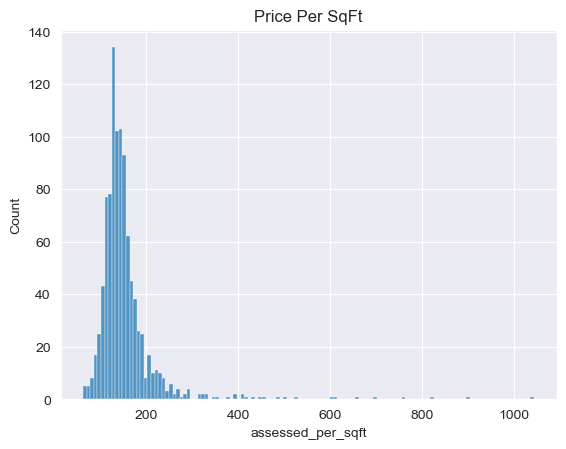

In [58]:
# Histogram of price_per_sqft
sns.histplot(data=sample_df, x="assessed_per_sqft").set_title("Price Per SqFt")

Text(0.5, 1.0, 'log(Price) Per SqFt')

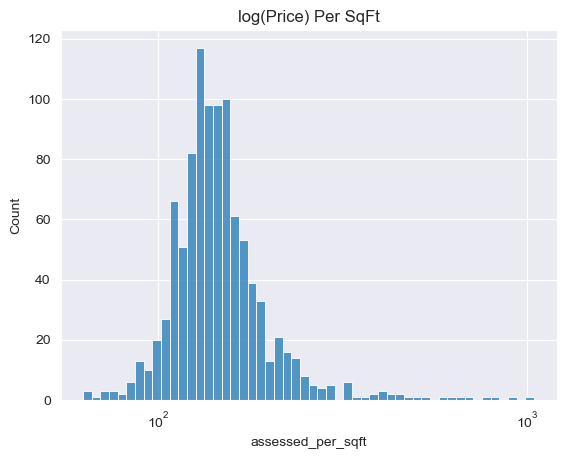

In [60]:
# Histogram of price_per_sqft
sns.histplot(data=sample_df, x="assessed_per_sqft", log_scale=True).set_title("log(Price) Per SqFt")

Text(0.5, 1.0, 'Assessed Values')

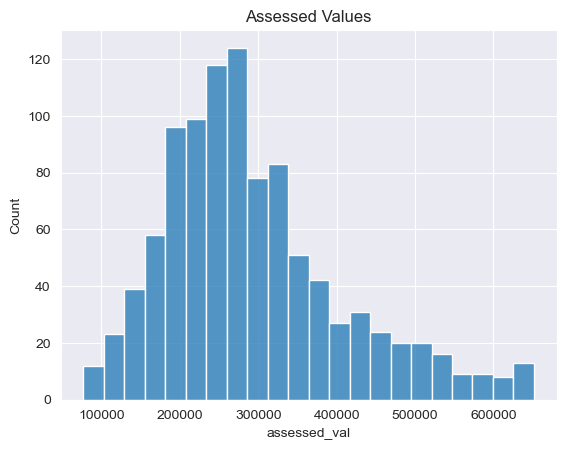

In [57]:
# Histogram of assessed values
sns.histplot(data=sample_df, x="assessed_val").set_title('Assessed Values')

<Axes: xlabel='assessed_val', ylabel='Count'>

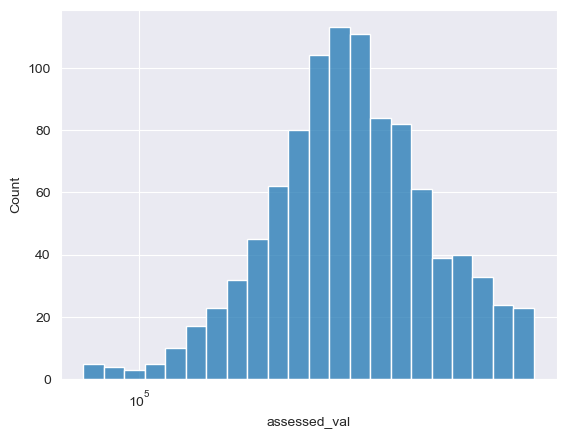

In [19]:
# Histogram with log transformation
sns.histplot(data=sample_df, x="assessed_val", log_scale=True)

<Axes: xlabel='transformed_data', ylabel='Count'>

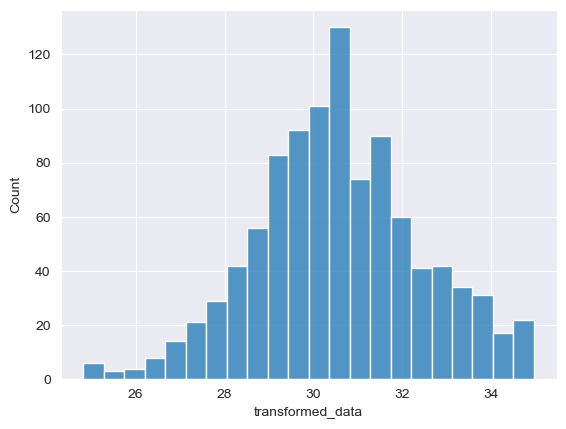

In [20]:

transformed_data, lambda_value = boxcox(sample_df['assessed_val'])
sample_df['transformed_data'] = transformed_data
sns.histplot(data=sample_df, x="transformed_data")

## Test normality with Shapiro-Wilk Test
The Shapiro-Wilk test evaluates a data set and quantifies how likely it is that the data was sampled from a Gaussian distribution. This is believed to be a reliable test for normality if the dataset is not too large, i.e. under 5,000.



In [21]:
stat, p = shapiro(np.log(sample_df['assessed_val']))
print(f"H-null: the distribution is normal\nH-alternative: the distribution is not normal")
print(f'Statistic: {stat} | p: {p}')
alpha = 0.05  # General alpha for 95% confidence
if p > alpha:
    print(f'Sample looks normally distributed (fail to reject H-null).')
else:
    print('Sample does not look normally distributed (reject H-null in favor of H-alternative).')

H-null: the distribution is normal
H-alternative: the distribution is not normal
Statistic: 0.9932213979670642 | p: 0.00016045202031811107
Sample does not look normally distributed (reject H-null in favor of H-alternative).


In [22]:
# Test if box cox transformation normalizes the data
stat, p = shapiro(sample_df['transformed_data'])
print(f"H-null: the distribution is normal\nH-alternative: the distribution is not normal")
print(f'Statistic: {stat} | p: {p}')
alpha = 0.05  # General alpha for 95% confidence
if p > alpha:
    print(f'Sample looks normally distributed (fail to reject H-null).')
else:
    print('Sample does not look normally distributed (reject H-null in favor of H-alternative).')

H-null: the distribution is normal
H-alternative: the distribution is not normal
Statistic: 0.9941924750727767 | p: 0.0006524084477287154
Sample does not look normally distributed (reject H-null in favor of H-alternative).


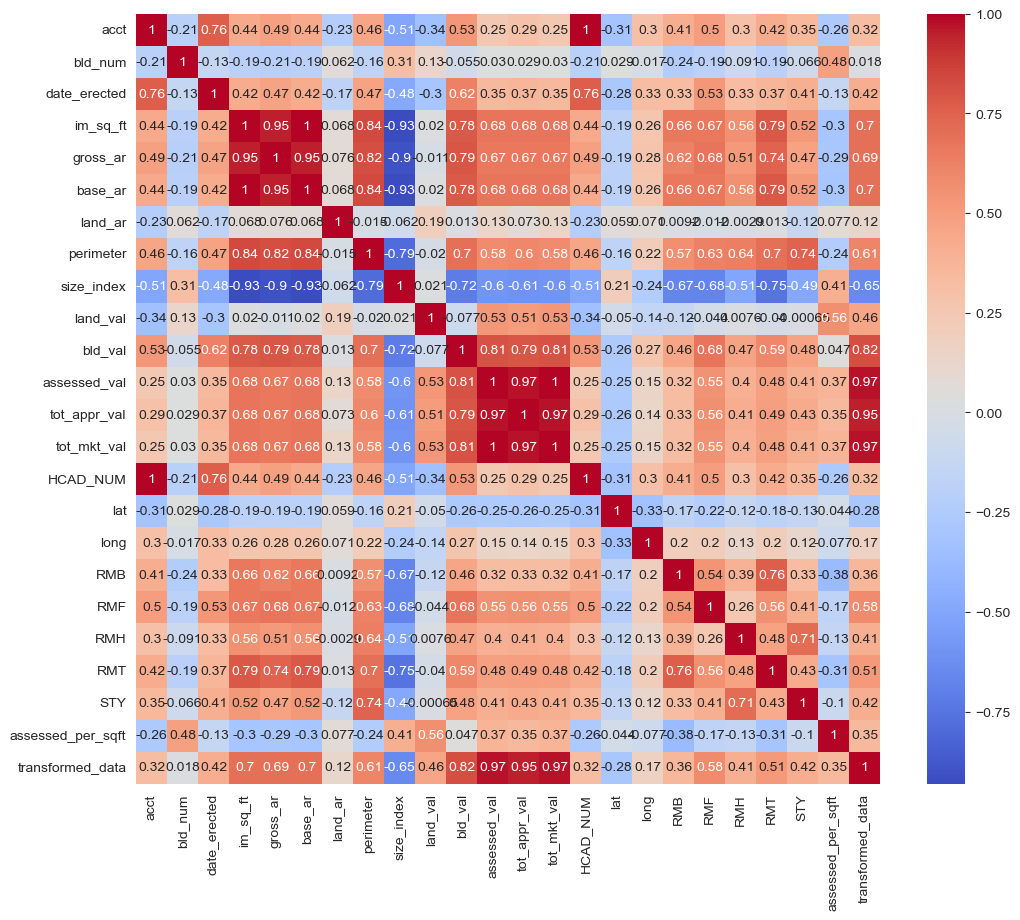

In [23]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.show()

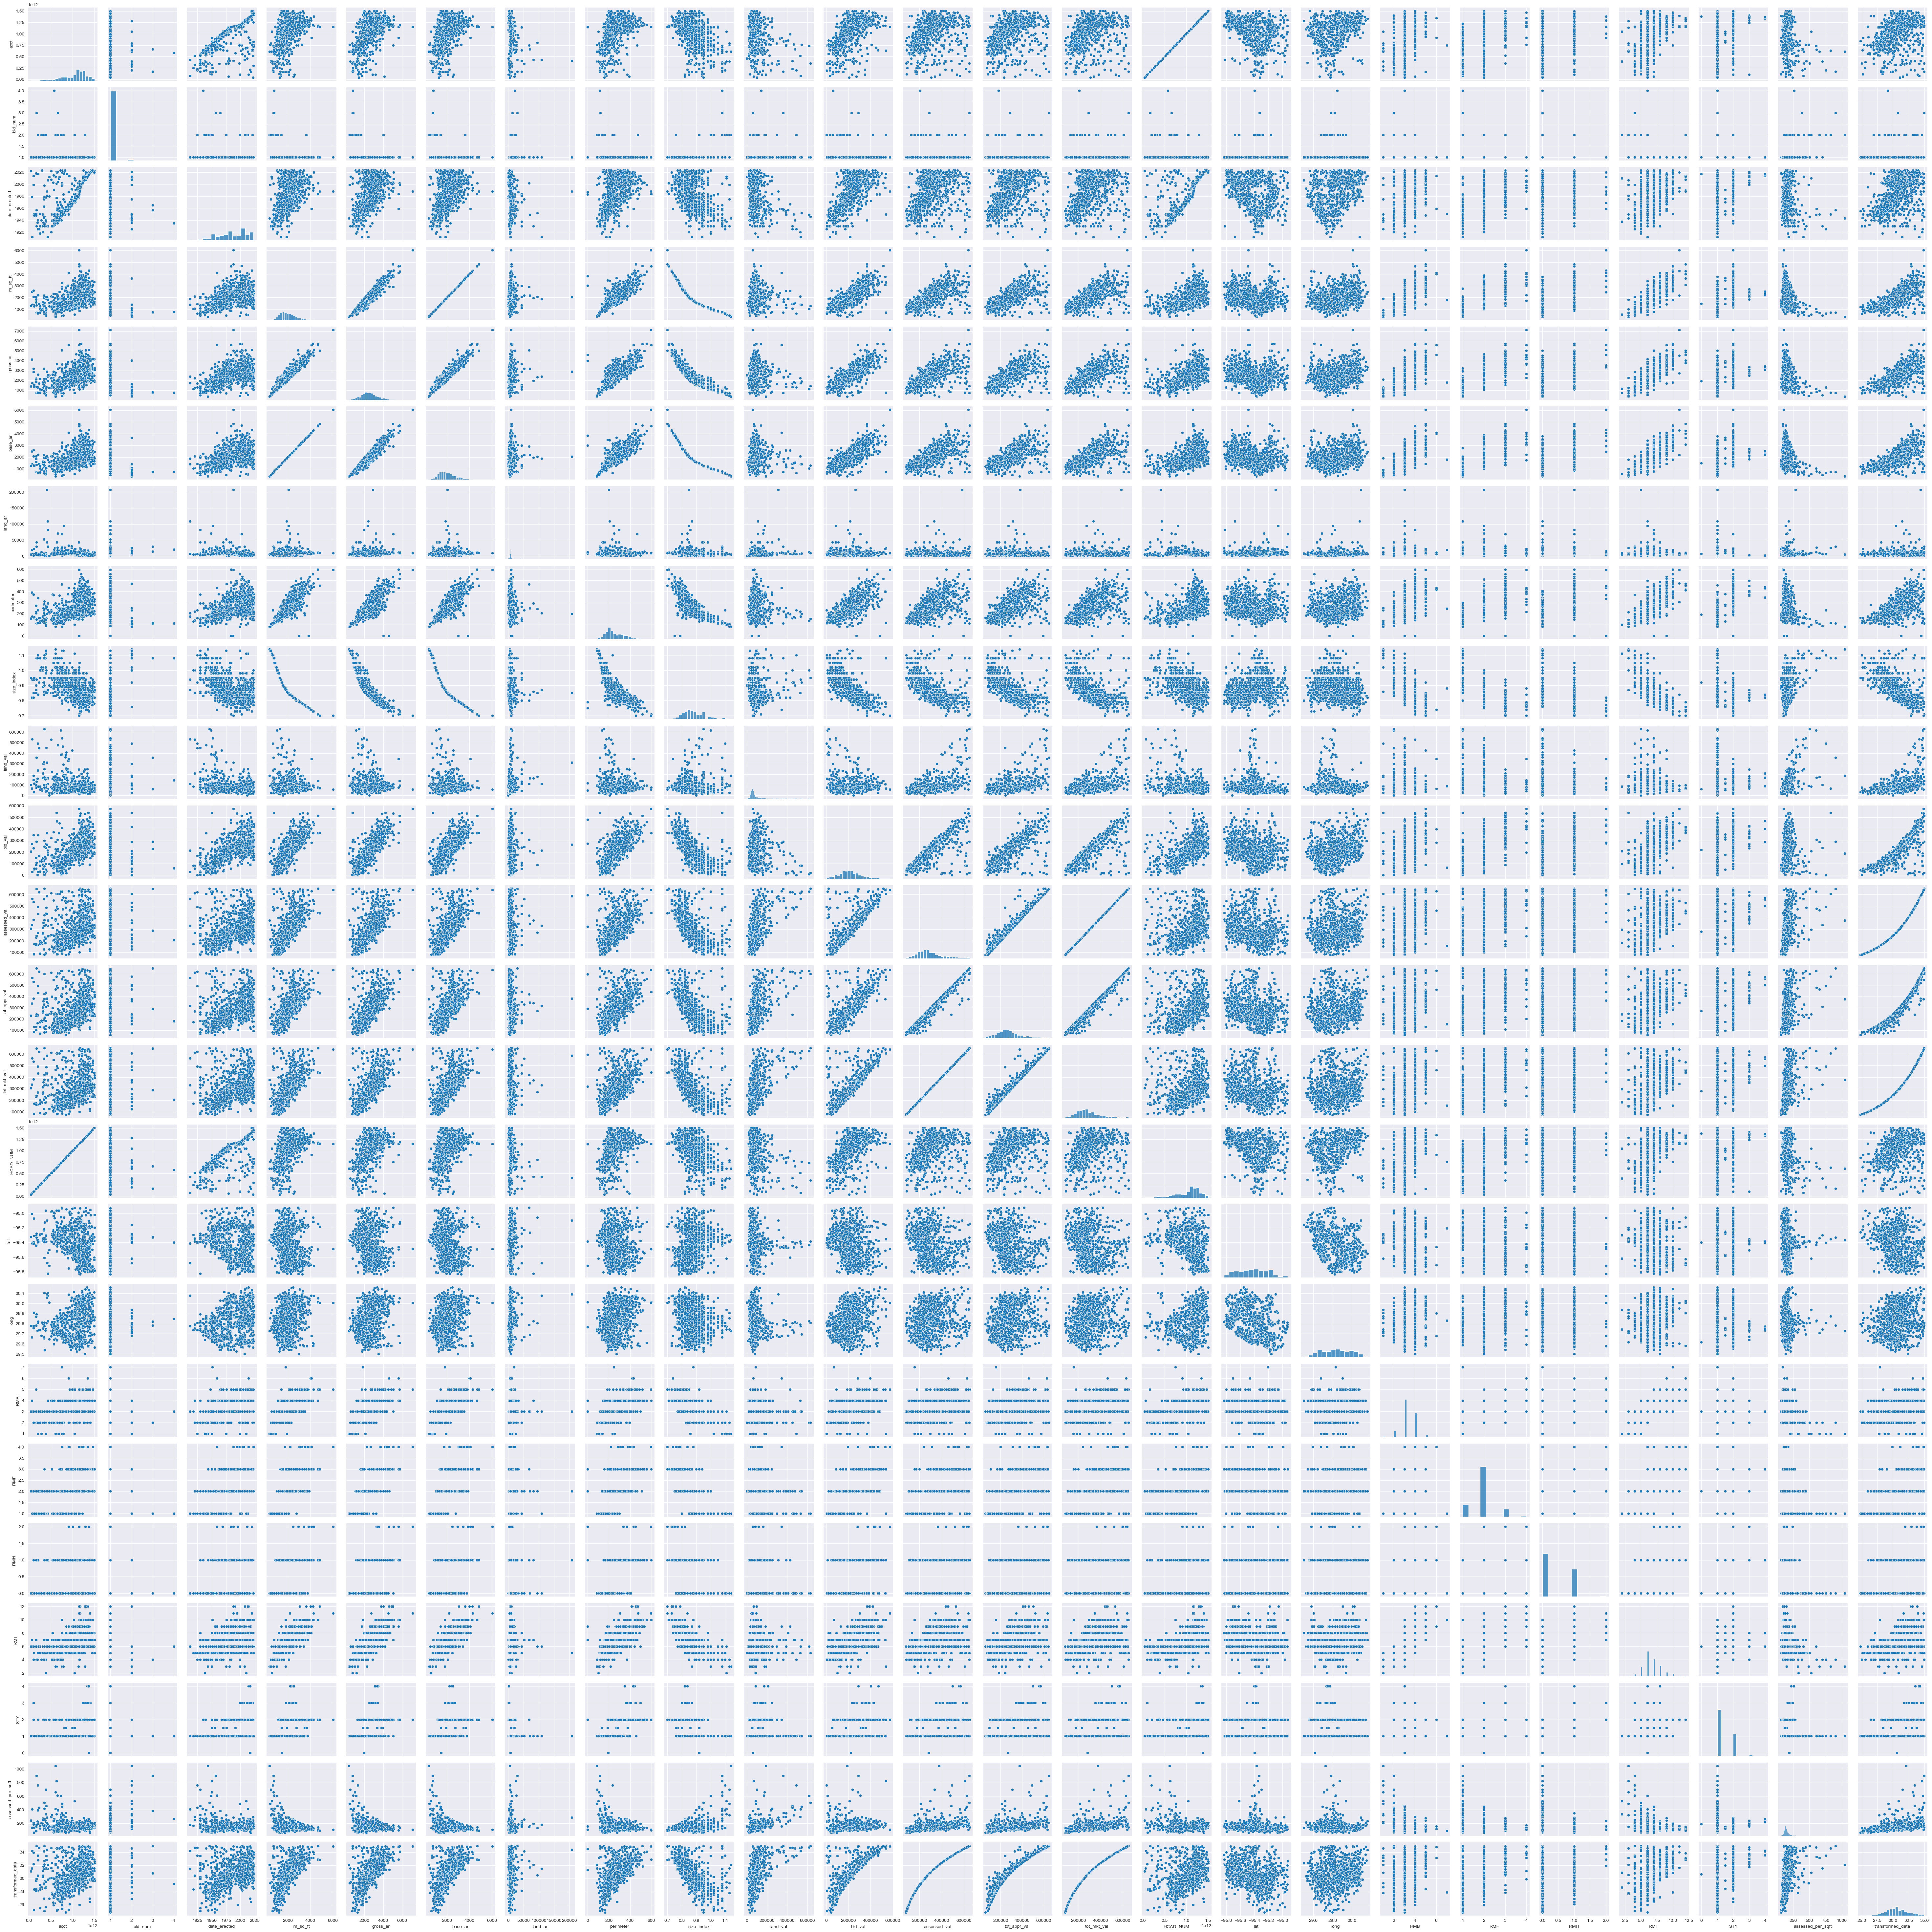

In [24]:
sns.pairplot(data=sample_df, vars=list(sample_df.columns))

## Train, Test, Split!
The training and testing sets get split, but I will need to see some examples to see if there are indexes on the y's

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Feature Ranking

In [26]:
rfc = RandomForestClassifier()

In [27]:
rfc.fit(x_train, y_train)
importance = rfc.feature_importances_

In [28]:
feature_importance = pd.Series(importance, index=x_train.columns)
print(feature_importance.sort_values(ascending=False))

long                 0.130400
lat                  0.129829
im_sq_ft             0.121242
assessed_per_sqft    0.120654
assessed_per_sqft    0.119730
perimeter            0.118317
date_erected         0.111333
RMT                  0.056085
RMB                  0.032474
RMH                  0.021542
RMF                  0.019600
STY                  0.018793
dtype: float64


## Extra Trees Regressor


In [29]:
etc = ExtraTreesRegressor(random_state=42)

In [30]:
etc.fit(x_train, y_train)
etc.feature_importances_

array([0.01419175, 0.31506201, 0.18570849, 0.08649304, 0.00447999,
       0.1492518 , 0.02715688, 0.02436423, 0.00306673, 0.00494488,
       0.00506869, 0.18021151])

In [31]:
cross_val_score(etc, x_train, y_train, cv=5, n_jobs=-1).mean()

0.9543066285017128

In [32]:
param_grid = {
    'n_estimators': [100, 750, 800],
    'min_samples_leaf': [1, 3, 5],
    'max_features': [3, 5, 7, 10],
    'criterion': ['absolute_error', 'friedman_mse']
}

In [33]:
# n_jobs will determine the amount of parallel process and how much memory will be used. -1 will use ALL cores, set to 50% of virtual cores to be safe and not use all the memory.
etc_cv = GridSearchCV(etc, param_grid, cv=5, n_jobs=-1, scoring='r2')

In [34]:
etc_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error', 'friedman_mse'],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 750, 800]},
             scoring='r2')

In [35]:
etc_cv.best_params_

{'criterion': 'friedman_mse',
 'max_features': 10,
 'min_samples_leaf': 1,
 'n_estimators': 800}

In [36]:
etc_cv.best_score_

0.9549826431702853

In [37]:
etc_pred = etc_cv.predict(x_test)

In [38]:
etc_mae = mean_absolute_error(y_test, etc_pred)
etc_mse = mean_squared_error(y_test, etc_pred)
etc_r2 = r2_score(y_test, etc_pred)
print(f"MAE: {etc_mae}\nMSE: {etc_mse}\nR Squared: {etc_r2}\n")

MAE: 11162.629725
MSE: 554412503.336174
R Squared: 0.9599386551228056



In [39]:
# Save model
import joblib

joblib.dump(etc_cv, 'Models/etc.pkl')

# load
# joblib.load('etc.pkl')

['etc.pkl']

# Residual Analysis

In [40]:
actual = y_test.to_list()
predicted = etc_cv.predict(x_test)

etc_residuals = pd.DataFrame({'actual': actual, "predicted": predicted, })
etc_residuals['residuals'] = etc_residuals['actual'] - etc_residuals['predicted']
etc_residuals

actual     predicted    residuals
0    278212.0  277632.29375    579.70625
1    628432.0  528997.00125  99434.99875
2    281690.0  280781.45625    908.54375
3    501000.0  484241.11875  16758.88125
4    174247.0  193299.28250 -19052.28250
..        ...           ...          ...
195  171176.0  169715.99750   1460.00250
196  330199.0  325467.80125   4731.19875
197  288457.0  295750.49625  -7293.49625
198  305561.0  306037.20875   -476.20875
199  337420.0  361868.75250 -24448.75250

[200 rows x 3 columns]

<Axes: xlabel='actual', ylabel='predicted'>

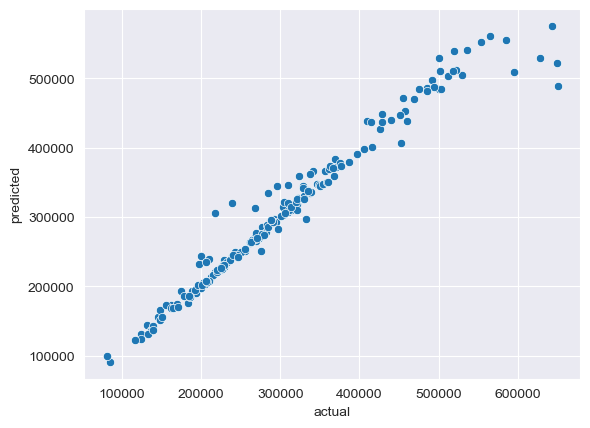

In [41]:
sns.scatterplot(data=etc_residuals, x='actual', y='predicted')

<Axes: xlabel='actual', ylabel='residuals'>

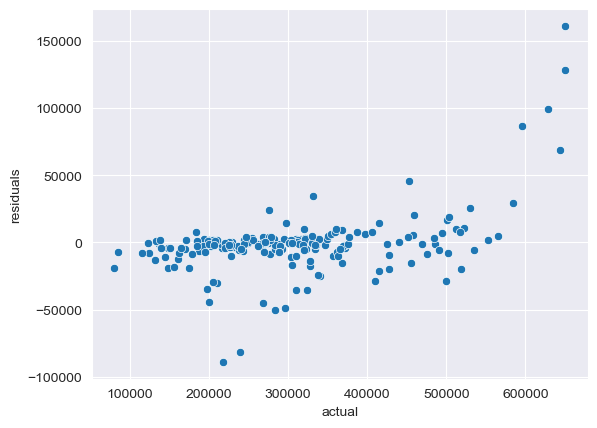

In [42]:
sns.scatterplot(data=etc_residuals, x='actual', y='residuals')

## Gradient Boost
The assessed values are not normally distributed, but are skewed right. They will be log transformed and the predicted values will be expectationaled back to assess the residuals.

In [43]:
gbr = GradientBoostingRegressor()

In [44]:
param_grid = {
    'n_estimators': [750, 1000, 2000],
    'learning_rate': [0.001, 0.002, 0.005],
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [3, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['absolute_error', 'friedman_mse'],
}

In [45]:
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=-1, scoring='r2')

In [47]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

C:\Users\Blake\miniconda3\envs\HouseProtestValues\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1620 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1202 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Blake\miniconda3\envs\HouseProtestValues\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Blake\miniconda3\envs\HouseProtestValues\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Blake\miniconda3\envs\HouseProtestValues\Lib\site-packages\sklearn\base.py", line 666, i

In [48]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 10348.762772896824
MSE: 397916101.7620149
R Squared: 0.9712469432255736



In [49]:
gbr_cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.005,
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 2000}

In [50]:
gbr_cv.best_score_

0.9701011392299591

In [51]:
joblib.dump(gbr_cv, 'Models/gbr.pkl')

# load
# joblib.load('gbr.pkl')

['gbr.pkl']

In [52]:
gbr_residual_df = pd.DataFrame({'actual': actual, "predicted": gbr_pred, })
gbr_residual_df['residuals'] = gbr_residual_df['actual'] - gbr_residual_df['predicted']

<Axes: xlabel='actual', ylabel='predicted'>

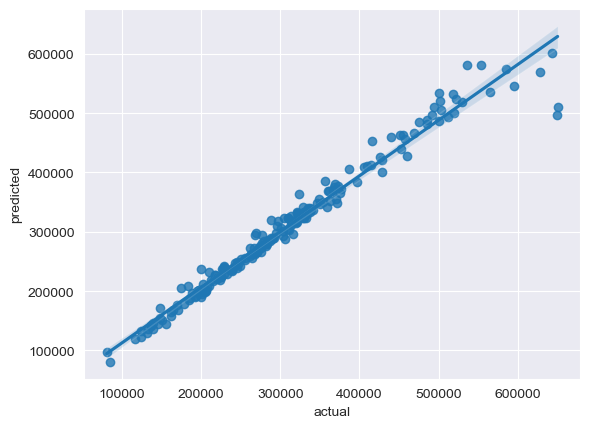

In [53]:
sns.regplot(gbr_residual_df, x='actual', y='predicted')

<Axes: xlabel='actual', ylabel='residuals'>

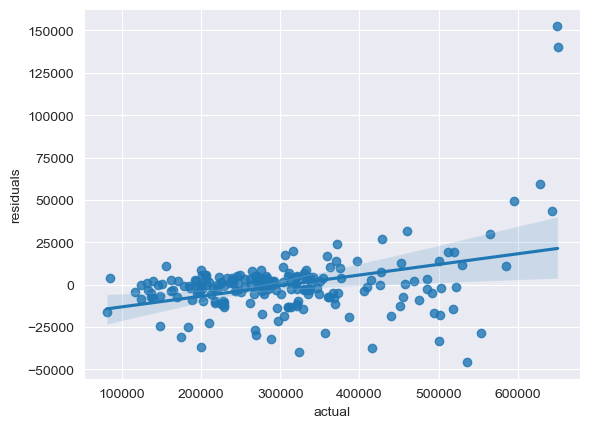

In [54]:
sns.regplot(gbr_residual_df, x='actual', y='residuals')

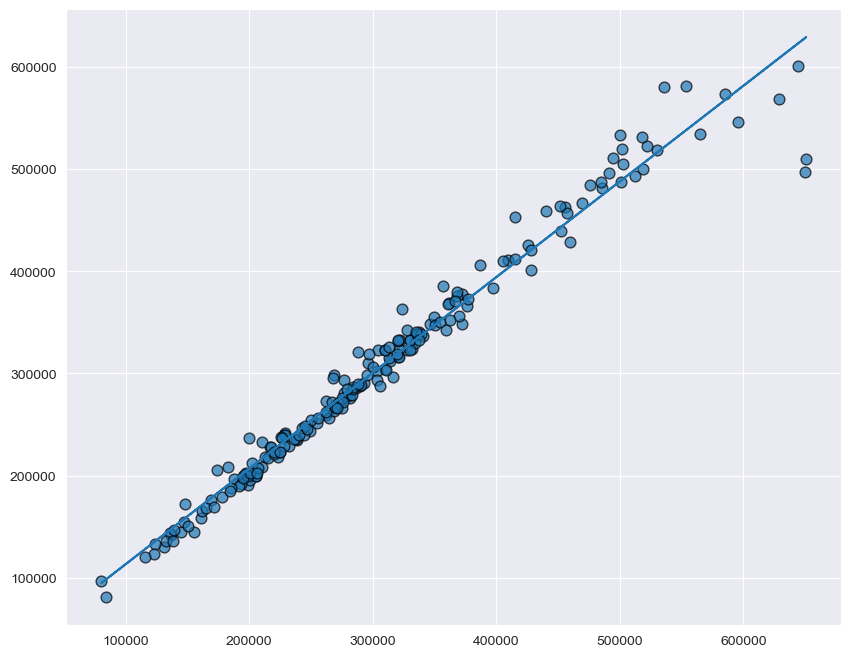

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(gbr_residual_df['actual'], gbr_residual_df['predicted'], s=60, alpha=0.7, edgecolors='k')
b, a = np.polyfit(gbr_residual_df['actual'], gbr_residual_df['predicted'], 1)
ax.plot(gbr_residual_df['actual'], b * gbr_residual_df['actual'] + a)
ax.annotate(f"R-Squared = {gbr_r2}", (0, 1))
plt.show()